## **INTRODUCTION**

In this notebook we take a look at importing image files from Google Drive. The images are images of objects. Each folder in the set is that of forest,building,street,mountain and glacier.
Our aim is to create an import pipeline and to predict if a previously unseen image is either forest,building,street,mountain or glacier.

## **Importing Essential Libraries**




In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential

from keras.layers import Convolution2D

from keras.layers import MaxPooling2D
from keras.layers import Flatten

from keras.layers import Dense
from keras.layers import BatchNormalization

from sklearn.metrics import classification_report, confusion_matrix
import os
import seaborn as sn; sn.set(font_scale=1.4)
from keras import models, layers, optimizers 

SEED = 2209
import os
import random as rn
import numpy as np
import tensorflow



os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tensorflow.random.set_seed(SEED)
rn.seed(SEED)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Authorizing Access to Google Cloud**

The file is archived as a ZIP file in Google Drive (in the same folder as this Colab notebook). It is set as shared and the shared link used below.

Note the original folder structure

**Train**
BUILDING
FOREST
GLACIER
MOUNTAIN
SEA
STREET

**Test**
BUILDING
FOREST
GLACIER
MOUNTAIN
SEA
STREET

The images were originally stored in the structure above inside a folder named Object.This folder was compressed as a ZIP file and uploaded to Google Drive.

In [2]:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
fid = drive.ListFile({'q':"title='object.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Object.zip')

In [5]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

## **Loading Images in Google Collab instance**

In [6]:
!unzip Object.zip

Streaming output truncated to the last 5000 lines.
  inflating: Object/Train/mountain/7551.jpg  
  inflating: Object/Train/mountain/7560.jpg  
  inflating: Object/Train/mountain/7565.jpg  
  inflating: Object/Train/mountain/7578.jpg  
  inflating: Object/Train/mountain/7581.jpg  
  inflating: Object/Train/mountain/7586.jpg  
  inflating: Object/Train/mountain/7647.jpg  
  inflating: Object/Train/mountain/7652.jpg  
  inflating: Object/Train/mountain/7654.jpg  
  inflating: Object/Train/mountain/7662.jpg  
  inflating: Object/Train/mountain/767.jpg  
  inflating: Object/Train/mountain/7672.jpg  
  inflating: Object/Train/mountain/7679.jpg  
  inflating: Object/Train/mountain/7681.jpg  
  inflating: Object/Train/mountain/7693.jpg  
  inflating: Object/Train/mountain/7695.jpg  
  inflating: Object/Train/mountain/7698.jpg  
  inflating: Object/Train/mountain/7700.jpg  
  inflating: Object/Train/mountain/771.jpg  
  inflating: Object/Train/mountain/7715.jpg  
  inflating: Object/Train/mount

In [7]:
PATH = '/content/Object'

In [8]:
train_dir = os.path.join(PATH,
                         'Train')
test_dir = os.path.join(PATH,
                        'Test')
pred_dir="/content/drive/My Drive/new_pred"

## **Rescaling and Augmenting Our Data**

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip=True,shear_range=0.2,  
    zoom_range=0.2, validation_split=0.1)

In [10]:
test_datagen = ImageDataGenerator(rescale = 1./255.)

In [11]:
test1_datagen = ImageDataGenerator(rescale = 1./255.)

In [12]:
pred_datagen = ImageDataGenerator(rescale = 1./255.)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
train_generator=train_datagen.flow_from_directory(
      train_dir,
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='training')

Found 12632 images belonging to 6 classes.


In [14]:
validation_generator=train_datagen.flow_from_directory(
      train_dir,
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='validation')

Found 1402 images belonging to 6 classes.


In [15]:
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150,150),
    batch_size=64,
    class_mode='sparse',
    seed=2209)

Found 3000 images belonging to 6 classes.


In [16]:
test2_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150,150),
    batch_size=64,
    class_mode='sparse',
    shuffle=False)


Found 3000 images belonging to 6 classes.


In [17]:
pred_generator = pred_datagen.flow_from_directory(
    "/content/drive/My Drive/new_pred", 
    target_size=(150,150),
    batch_size=20,
    class_mode=None,
    shuffle=False)

Found 19 images belonging to 1 classes.


## **Building and Training our Models**

## **ANN**

In [18]:

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard
from keras.layers.convolutional import Conv2D

In [19]:
model1 = Sequential()
model1.add(Flatten())
model1.add(Dense(256))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.2))
model1.add(Dense(6))
model1.add(Activation('softmax'))


In [20]:
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history1=model1.fit_generator(
  train_generator,
  steps_per_epoch=10,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=10,
  verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
10/10 [==============================] - 7s 683ms/step - loss: 2.2872 - accuracy: 0.3625 - val_loss: 27.1499 - val_accuracy: 0.1922
Epoch 2/30
10/10 [==============================] - 6s 644ms/step - loss: 1.5671 - accuracy: 0.4234 - val_loss: 11.4265 - val_accuracy: 0.1813
Epoch 3/30
10/10 [==============================] - 6s 643ms/step - loss: 1.4593 - accuracy: 0.4625 - val_loss: 6.6092 - val_accuracy: 0.2375
Epoch 4/30
10/10 [==============================] - 6s 644ms/step - loss: 1.5116 - accuracy: 0.4313 - val_loss: 4.1867 - val_accuracy: 0.3219
Epoch 5/30
10/10 [==============================] - 6s 646ms/step - loss: 1.4582 - accuracy: 0.4406 - val_loss: 3.5297 - val_accuracy: 0.3391
Epoch 6/30
10/10 [==============================] - 7s 652ms/step - loss: 1.3224 - accuracy: 0.4922 - val_loss: 2.8041 - val_accuracy: 0.3375
Epoch 7/30
10/10 [==============================] - 6s 644ms/step - lo

In [22]:
accuracy = model1.evaluate_generator(test_generator, steps=int(3000)//64,verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
46/46 - 3s - loss: 1.3292 - accuracy: 0.4776
Accuracy of the model on the test set:  0.47758153080940247


In [23]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history1.history['accuracy']
val_acc=history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']



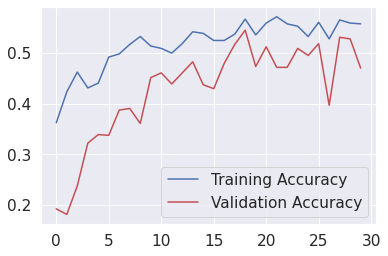

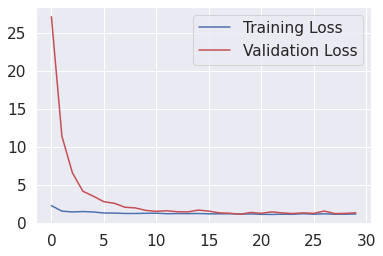

In [24]:
epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

## **CNN**

In [25]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(150,150,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(15, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(15, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(6, activation='softmax'))

In [26]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)            

In [27]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history2=model2.fit_generator(
  train_generator,
  steps_per_epoch=10,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=10,
  verbose=1)

Epoch 1/30
10/10 [==============================] - 7s 663ms/step - loss: 1.9580 - accuracy: 0.2250 - val_loss: 2.0173 - val_accuracy: 0.1484
Epoch 2/30
10/10 [==============================] - 7s 651ms/step - loss: 1.7641 - accuracy: 0.2641 - val_loss: 1.8679 - val_accuracy: 0.1625
Epoch 3/30
10/10 [==============================] - 6s 636ms/step - loss: 1.6936 - accuracy: 0.2950 - val_loss: 1.7812 - val_accuracy: 0.2125
Epoch 4/30
10/10 [==============================] - 7s 659ms/step - loss: 1.6121 - accuracy: 0.3500 - val_loss: 1.7346 - val_accuracy: 0.2703
Epoch 5/30
10/10 [==============================] - 7s 658ms/step - loss: 1.6024 - accuracy: 0.3562 - val_loss: 1.7247 - val_accuracy: 0.2859
Epoch 6/30
10/10 [==============================] - 7s 653ms/step - loss: 1.5043 - accuracy: 0.4156 - val_loss: 1.7407 - val_accuracy: 0.2609
Epoch 7/30
10/10 [==============================] - 6s 649ms/step - loss: 1.4773 - accuracy: 0.4266 - val_loss: 1.7422 - val_accuracy: 0.3125
Epoch 

In [28]:
accuracy = model2.evaluate_generator(test_generator, steps=int(3000)//64,verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

46/46 - 3s - loss: 1.3020 - accuracy: 0.5017
Accuracy of the model on the test set:  0.50169837474823


In [29]:
%matplotlib inline
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']


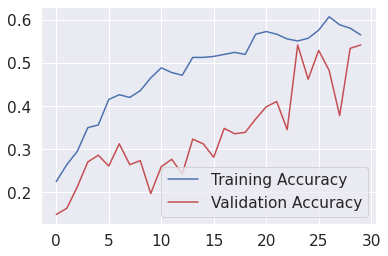

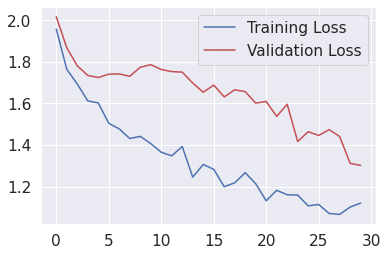

In [30]:
epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

# **DenseNet121**

In [31]:
from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
import numpy as np 
from keras.applications.densenet import DenseNet121
import keras

In [32]:
base_model1=DenseNet121(include_top=False, weights= 'imagenet',  input_shape=(150,150,3), pooling='avg')
base_model1.trainable = False

29089792/29084464 [==============================] - 0s 0us/step


In [33]:
x = layers.Flatten()(base_model1.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

In [35]:
transfer_model1 = Model(base_model1.input, x) 
transfer_model1.compile(optimizer =keras.optimizers.Nadam(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [36]:
transfer_model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [37]:
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
history3 = transfer_model1.fit_generator(
            train_generator,
            steps_per_epoch=10,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=10,
            callbacks=[reduce],
            verbose=1)

Epoch 1/30
10/10 [==============================] - 8s 827ms/step - loss: 2.3253 - accuracy: 0.1875 - val_loss: 1.6213 - val_accuracy: 0.3531
Epoch 2/30
10/10 [==============================] - 7s 696ms/step - loss: 1.8927 - accuracy: 0.2844 - val_loss: 1.3901 - val_accuracy: 0.4578
Epoch 3/30
10/10 [==============================] - 7s 691ms/step - loss: 1.5839 - accuracy: 0.3938 - val_loss: 1.1539 - val_accuracy: 0.6172
Epoch 4/30
10/10 [==============================] - 7s 694ms/step - loss: 1.3770 - accuracy: 0.4812 - val_loss: 0.9978 - val_accuracy: 0.6953
Epoch 5/30
10/10 [==============================] - 7s 700ms/step - loss: 1.2876 - accuracy: 0.5516 - val_loss: 0.8642 - val_accuracy: 0.7641
Epoch 6/30
10/10 [==============================] - 7s 694ms/step - loss: 1.1139 - accuracy: 0.5781 - val_loss: 0.7748 - val_accuracy: 0.7922
Epoch 7/30
10/10 [==============================] - 7s 692ms/step - loss: 1.0644 - accuracy: 0.6156 - val_loss: 0.7332 - val_accuracy: 0.7906
Epoch 

In [38]:
accuracy1=transfer_model1.evaluate_generator(test_generator, steps=3000//64,verbose=2)
print('Accuracy of the model on the test set: ',accuracy1[1])

46/46 - 4s - loss: 0.3429 - accuracy: 0.8798
Accuracy of the model on the test set:  0.879755437374115


In [39]:
%matplotlib inline
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']

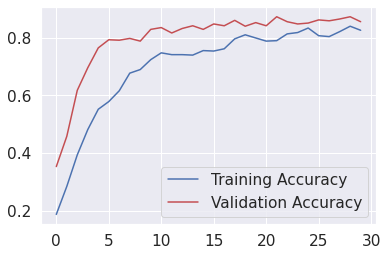

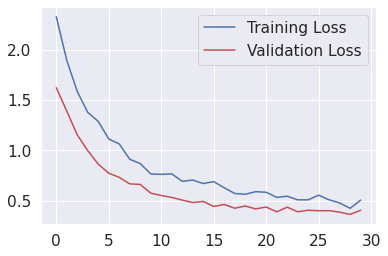

In [40]:
epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

## **ResNet50**

In [41]:
from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
import numpy as np 
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
import keras

In [42]:
##base_model2=ResNet50(include_top=False, weights= 'imagenet',  input_shape=(150,150,3), pooling='avg')
##base_model2.trainable = False##

base_model2 = ResNet50V2(include_top=False, weights='imagenet',input_shape=(150,150,3))
base_model2.trainable = False

94674944/94668760 [==============================] - 1s 0us/step


In [43]:
x = Conv2D(128, (3, 3),activation='relu')(base_model2.output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

model = Model(inputs=base_model2.input, outputs=x)

In [45]:
transfer_model2 = Model(model.input, x) 
transfer_model2.compile(optimizer =keras.optimizers.Nadam(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [46]:
transfer_model2.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [47]:
reduce = tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto')
history4 = transfer_model2.fit_generator(
            train_generator,
            steps_per_epoch=10,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=10,
            callbacks=[reduce],
            verbose=1)

Epoch 1/30
10/10 [==============================] - 8s 772ms/step - loss: 1.8386 - acc: 0.4422 - val_loss: 0.8449 - val_acc: 0.7188
Epoch 2/30
10/10 [==============================] - 7s 694ms/step - loss: 0.7495 - acc: 0.7484 - val_loss: 0.5116 - val_acc: 0.8203
Epoch 3/30
10/10 [==============================] - 7s 696ms/step - loss: 0.4938 - acc: 0.8203 - val_loss: 0.4522 - val_acc: 0.8422
Epoch 4/30
10/10 [==============================] - 7s 694ms/step - loss: 0.4536 - acc: 0.8641 - val_loss: 0.4626 - val_acc: 0.8453
Epoch 5/30
10/10 [==============================] - 7s 702ms/step - loss: 0.4138 - acc: 0.8562 - val_loss: 0.3666 - val_acc: 0.8547
Epoch 6/30
10/10 [==============================] - 7s 699ms/step - loss: 0.3285 - acc: 0.8844 - val_loss: 0.3838 - val_acc: 0.8766
Epoch 7/30
10/10 [==============================] - 7s 704ms/step - loss: 0.4246 - acc: 0.8609 - val_loss: 0.4221 - val_acc: 0.8750
Epoch 8/30
10/10 [==============================] - 7s 709ms/step - loss: 0.

In [48]:
accuracy2=transfer_model2.evaluate_generator(test_generator, steps=3000//64,verbose=2)
print('Accuracy of the model on the test set: ',accuracy2[1])

46/46 - 4s - loss: 0.3445 - acc: 0.8750
Accuracy of the model on the test set:  0.875


In [49]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history4.history['acc']
val_acc=history4.history['val_acc']
loss=history4.history['loss']
val_loss=history4.history['val_loss']

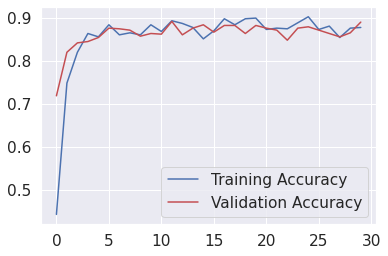

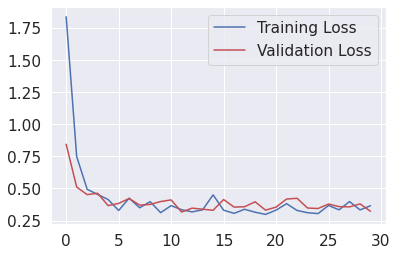

In [50]:

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

# **vgg 16**

In [51]:
from keras.applications import VGG16
from keras import models, layers, optimizers

In [52]:
conv_base = VGG16(weights = 'imagenet',include_top = False,input_shape = (150,150,3))

58892288/58889256 [==============================] - 1s 0us/step


In [53]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [56]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [57]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Nadam(lr=2e-5), metrics=['acc'])

In [58]:
import tensorflow as tf
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='auto')

In [59]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch=10,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=10,
  callbacks=[reduce],
  verbose=1)

Epoch 1/30
10/10 [==============================] - 8s 849ms/step - loss: 2.0269 - acc: 0.2125 - val_loss: 1.4890 - val_acc: 0.3906
Epoch 2/30
10/10 [==============================] - 8s 815ms/step - loss: 1.4620 - acc: 0.3953 - val_loss: 0.9119 - val_acc: 0.7188
Epoch 3/30
10/10 [==============================] - 8s 817ms/step - loss: 0.9681 - acc: 0.6109 - val_loss: 0.6701 - val_acc: 0.7500
Epoch 4/30
10/10 [==============================] - 8s 818ms/step - loss: 0.8807 - acc: 0.6625 - val_loss: 0.5864 - val_acc: 0.7906
Epoch 5/30
10/10 [==============================] - 8s 824ms/step - loss: 0.7196 - acc: 0.7125 - val_loss: 0.5242 - val_acc: 0.8156
Epoch 6/30
10/10 [==============================] - 8s 817ms/step - loss: 0.6652 - acc: 0.7328 - val_loss: 0.5138 - val_acc: 0.8250
Epoch 7/30
10/10 [==============================] - 8s 812ms/step - loss: 0.5862 - acc: 0.7922 - val_loss: 0.4334 - val_acc: 0.8562
Epoch 8/30
10/10 [==============================] - 8s 808ms/step - loss: 0.

In [60]:
accuracy = model.evaluate_generator(test_generator, steps=int(3000)//64,verbose=2)
print('Accuracy of the model on the test set: ',accuracy[1])

46/46 - 5s - loss: 0.2609 - acc: 0.9130
Accuracy of the model on the test set:  0.9130434989929199


In [61]:
# Commented out IPython magic to ensure Python compatibility.
#Evaluating Accuracy and Loss of the model
# %matplotlib inline
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

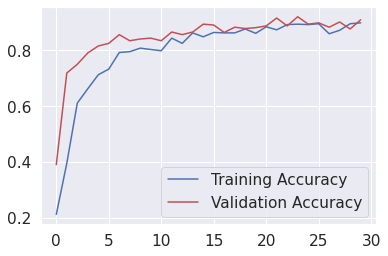

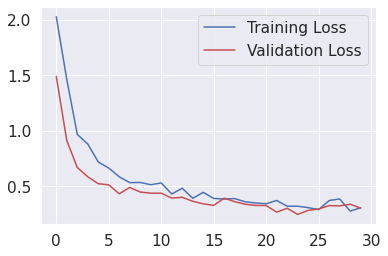

In [62]:
#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

## **Evaluating Result**

Creating Confusion Matrix

In [63]:
Y_pred = model.predict_generator(test2_generator, 3000 // 64+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test2_generator.classes, y_pred))
print('Classification Report')
target_names = ["buildings","forest","glacier","mountain","sea","street"]
print(classification_report(test2_generator.classes, y_pred, target_names=target_names))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[393   1   1   1   3  38]
 [  0 470   0   3   1   0]
 [  4   3 479  48  17   2]
 [  0   3  60 447  13   2]
 [  3   5  22   6 472   2]
 [ 23   2   0   1   3 472]]
Classification Report
              precision    recall  f1-score   support

   buildings       0.93      0.90      0.91       437
      forest       0.97      0.99      0.98       474
     glacier       0.85      0.87      0.86       553
    mountain       0.88      0.85      0.87       525
         sea       0.93      0.93      0.93       510
      street       0.91      0.94      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



Heat Map

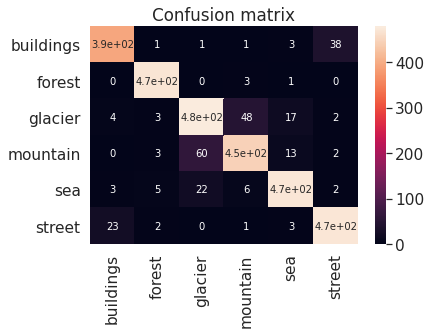

In [64]:

CM = confusion_matrix(test2_generator.classes, y_pred)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=target_names, 
           yticklabels=target_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## **Predicting Our Model on Unseen Data**

In [65]:
predictions =model.predict_generator(pred_generator,steps=1,verbose=1)

1/1 [==============================] - 0s 8ms/step


In [66]:
import pandas as pd
df = pd.DataFrame(predictions, columns =["buildings","forest","glacier","mountain","sea","street"])
print(df)

       buildings    forest   glacier      mountain           sea        street
0   3.486100e-06  0.000003  0.997939  2.005192e-03  3.762920e-05  1.108460e-05
1   2.108604e-02  0.003359  0.573446  1.502503e-01  3.523670e-02  2.166215e-01
2   5.321084e-04  0.000652  0.291635  7.022951e-01  4.404733e-03  4.813442e-04
3   5.888513e-04  0.000018  0.000020  1.246568e-06  4.098758e-05  9.993318e-01
4   9.716978e-01  0.000601  0.000207  7.863121e-05  7.173939e-04  2.669744e-02
5   9.979522e-01  0.000068  0.000004  1.409752e-06  1.514627e-05  1.959617e-03
6   5.645170e-07  0.999997  0.000001  9.354591e-07  2.607042e-07  8.849619e-08
7   1.357165e-05  0.999945  0.000009  2.353189e-05  5.390777e-06  3.811701e-06
8   5.954994e-02  0.000409  0.001294  4.067118e-04  5.745607e-03  9.325944e-01
9   1.486602e-04  0.000047  0.000662  1.976697e-04  9.985909e-01  3.535143e-04
10  7.203158e-03  0.006791  0.835931  1.239196e-01  1.933630e-02  6.819163e-03
11  7.705151e-02  0.003259  0.000207  3.580340e-05  

In [67]:
labels = df.idxmax(axis = 1)
df['Labels'] = labels

In [68]:
df.head()

,buildings,forest,glacier,mountain,sea,street,Labels
0,0.000003,0.000003,0.997939,0.002005,0.000038,0.000011,glacier
1,0.021086,0.003359,0.573446,0.150250,0.035237,0.216621,glacier
2,0.000532,0.000652,0.291635,0.702295,0.004405,0.000481,mountain
3,0.000589,0.000018,0.000020,0.000001,0.000041,0.999332,street
4,0.971698,0.000601,0.000207,0.000079,0.000717,0.026697,buildings


In [69]:
sample_training_images = next(pred_generator)

In [70]:
labels=df["Labels"]

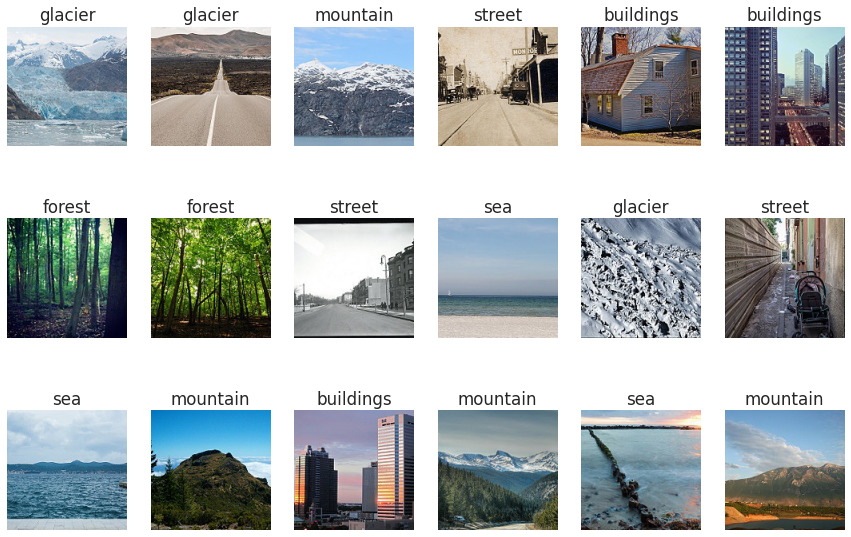

In [71]:
plt.figure(figsize=(15,10))
for i in range(18):
    plt.subplot(3, 6, i + 1)
    plt.axis('off')
    plt.imshow(sample_training_images[i])
    plt.title(labels[i])

## **CONCLUSION**

The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. Well, it can be understandable as there are buildings in the street. It has also trouble with glacier and moutain as well. It is hard for us to fully distinguish them. However, it can detects forest and sea very accurately!